In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_raw = pd.read_pickle("../petfinder-data/data/chicago_animals_cleaned.pkl")

In [31]:
df_raw.columns

Index(['id', 'age', 'gender', 'size', 'coat', 'name', 'organization_id',
       'organization_name', 'published_at', 'status_changed_at', 'los',
       'breed_primary', 'breed_secondary', 'breed_mixed', 'breed_unknown',
       'color_primary', 'color_secondary', 'color_tertiary',
       'good_with_children', 'good_with_dogs', 'good_with_cats',
       'attribute_spayed_neutered', 'attribute_house_trained',
       'attribute_declawed', 'attribute_special_needs',
       'attribute_shots_current'],
      dtype='object')

In [32]:
y = df_raw["los"]

# just choose something to play with for now
X = df_raw[["good_with_children", "good_with_dogs", "good_with_cats", "attribute_spayed_neutered", "attribute_house_trained", "attribute_special_needs", "attribute_shots_current", "breed_unknown"]].astype(bool)

In [33]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=312)

In [52]:
# set up hyperparameter search space for the random forest regressor
random_grid = {
    "bootstrap": [True, False],
    "max_depth": [int(x) for x in np.linspace(10, 110, num=11)],
    "max_features": ["auto", "sqrt", "log2"],
    # "max_leaf_nodes": None,
    # "max_samples": None,
    # "min_impurity_decrease": 0.0,
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 4, 8, 16],
    # "min_weight_fraction_leaf": 0.0,
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
}

In [53]:
# train the regressor
regr = RandomForestRegressor(max_depth=5, random_state=312, criterion="squared_error")
regr_random = RandomizedSearchCV(estimator=regr, param_distributions=random_grid, n_iter=100, cv=5, random_state=312, n_jobs=-1)

regr_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=5,
                                                   random_state=312),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 4, 8, 16],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=312)

In [55]:
# print out selected parameters
best_params = regr_random.best_params_

print(regr_random.best_score_)
print(best_params)

0.05780868737067017
{'n_estimators': 1400, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [58]:
# retrain using the best params
regr = RandomForestRegressor(n_jobs=-1, random_state=312).set_params(**best_params)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=8,
                      min_samples_split=16, n_estimators=1400, n_jobs=-1,
                      random_state=312)

In [59]:
# infer on test data
yhat = regr.predict(X_test)

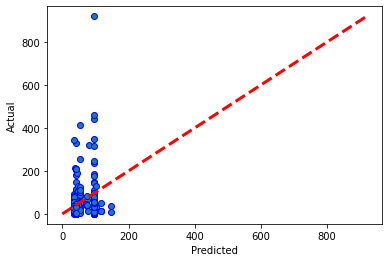

In [60]:
# plot inferences
fig, ax = plt.subplots()
ax.scatter(yhat, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [61]:
# evaluate performance
mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
r2 = r2_score(y_test, yhat)

metrics = {
    "mse": mse,
    "mae": mae,
    "r2": r2,
}
df_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["RandomForestRegressor"])
display(df_metrics)

,RandomForestRegressor
mse,6857.205376
mae,47.971266
r2,-0.000417
